# Analysis Plan: Do Teams with Higher Average Player Age Perform Worse?

## Research Question
Investigate whether teams with higher average player age show worse performance in tournaments using PCA and statistical analysis.

---

## Detailed Analysis Plan

### Step 1: Data Loading & Initial Exploration
- Import libraries (pandas, numpy, sklearn, matplotlib, seaborn, scipy)
- Load player statistics CSV from FBref scraping
- Examine structure with `.head()`, `.info()`, `.describe()`
- Check for missing values and data types
- Identify available columns: Player, Team, Position, Age, Goals, Assists, Minutes, Matches Played, Games Started, xG, npxG, xAG, Progressive Carries, Progressive Passes, Cards, League, Country

### Step 2: Data Cleaning
- Remove rows with missing critical values (Age, Team)
- Convert numeric columns from strings to appropriate types
- Handle missing values in performance metrics
- Validate data quality before analysis

### Step 3: Age Parsing
- Parse age format "YY-DDD" (years-days) to extract years only
- Create new `Age_Years` column with integer values
- Validate parsing with descriptive statistics
- Visualize age distribution by league

### Step 4: Team-Level Performance Aggregation
- **Group players by Team and League**
- Calculate team average age (mean across all players)
- Aggregate performance metrics per team:
  - Total goals, assists, xG, npxG, xAG
  - Total progressive carries and passes
  - Total yellow/red cards
  - Squad size and average matches per player
- Create normalized per-match metrics for fair comparison:
  - Goals per match, Assists per match
  - xG per match, xAG per match
  - Progressive actions per match

### Step 5: Feature Standardization
- Select 6-8 key performance metrics for PCA
- Apply `StandardScaler` to ensure mean=0, std=1
- Prevents variables with larger scales from dominating PCA
- Validate scaling worked correctly

### Step 6: PCA Application (Core Technique)
- Fit PCA to standardized performance metrics
- Create **scree plot** to visualize variance explained by each component
- Determine optimal number of components (typically 2-3 for 80-95% variance)
- Analyze **component loadings** to interpret what each PC represents:
  - PC1 might represent "overall attacking output"
  - PC2 might represent "playing style" (direct vs progressive)
- Transform team data into principal component scores
- Visualize teams in PC1-PC2 space, colored by average age

### Step 7: Correlation Analysis (Age vs Performance)
- **Primary research objective:** Test relationship between team age and performance
- Calculate Pearson correlation (linear relationships)
- Calculate Spearman correlation (monotonic relationships)
- Test correlations for:
  - Age vs individual metrics (goals, xG, assists, etc.)
  - Age vs principal component scores (PC1, PC2)
- Extract p-values for significance testing (α = 0.05)
- Create summary table showing all correlations with significance markers
- Visualize scatter plots with regression lines for key metrics

### Step 8: Age Group Comparison
- Categorize teams into age groups:
  - Young teams (< 25 years average)
  - Middle-aged teams (25-27 years)
  - Older teams (> 27 years)
- Compare performance distributions using box plots
- Run statistical tests:
  - **ANOVA** (if normally distributed)
  - **Kruskal-Wallis** (non-parametric alternative)
- Perform post-hoc pairwise comparisons to identify which groups differ
- Test differences in PC scores across age groups

### Step 9: K-Means Clustering (Optional Advanced Analysis)
- Apply clustering on PCA-transformed data (2D space)
- Use **elbow method** to find optimal number of clusters (k=2-5)
- Calculate **silhouette scores** to validate cluster quality
- Analyze average age within each performance cluster
- Test if age differs significantly across clusters using ANOVA
- Interpretation: Do high-performing teams tend to be younger/older?

### Step 10: Comprehensive Visualizations
Create 6-8 key visualizations:
1. **Scree plot** - variance explained by each PC
2. **PCA biplot** - teams in PC1-PC2 space, colored by age
3. **Component loadings** - which metrics contribute to each PC
4. **Age distribution** - histogram and league comparison
5. **Correlation heatmap** - age vs all performance metrics
6. **Scatter plots** - age vs key metrics (goals, xG) with regression lines
7. **Box plots** - age group performance comparison
8. **Cluster visualization** - if clustering applied

### Step 11: Statistical Summary & Conclusions
- Synthesize all findings into clear statements
- Answer research question with statistical evidence:
  - "Teams with higher average age show **[positive/negative/no]** correlation with performance"
  - Report correlation coefficients and p-values
  - Identify which specific metrics are affected
- Discuss **limitations**:
  - Observational data (no causation)
  - Confounding factors (league quality, budget, injuries)
  - Missing variables (tactics, coach experience)
- Provide data-driven conclusions with confidence levels
- Suggest future research directions

---

## Available Performance Metrics
Based on FBref standard stats table:
- **Attacking:** Goals, Assists, xG (Expected Goals), npxG (non-penalty xG), xAG (Expected Assists)
- **Playing Style:** Progressive Carries, Progressive Passes
- **Discipline:** Yellow Cards, Red Cards
- **Participation:** Minutes, Matches Played, Games Started

**Note:** Shooting stats (Shots, Shots on Target) and passing completion are NOT available in this dataset and would require separate scraping from FBref shooting/passing pages.

## Step 1: Data Loading and Initial Exploration

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway

warnings.filterwarnings('ignore')

In [6]:
# Load the player statistics data
df = pd.read_csv('../data_raw/playerStats.csv')


In [7]:
""""Player": get_stat("player"),
            "Squad": get_stat("team"),
            "Pos": get_stat("position"),
            "Age": get_stat("age"),
            "Gls": get_stat("goals"),
            "Ast": get_stat("assists"),
            "Min": get_stat("minutes"),
            "MP": get_stat("games"),
            "GS": get_stat("games_starts"),
            "xG": get_stat("xg"),
            "npxG": get_stat("npxg"),
            "xAG": get_stat("xg_assist"),
            "PrgC": get_stat("progressive_carries"),
            "PrgP": get_stat("progressive_passes"),
            "Yellow": get_stat("cards_yellow"),
            "Red": get_stat("cards_red"),
            "League": league_config["league"],
            "Country": league_config["country"],
            "Source": source,
            "Source_URL": build_stats_url(league_config),"""
rows = [
    "Player",
    "Team",
    "Position",
    "Age",
    "Goals",
    "Assists",
    "Minutes",
    "Matches Played",
    "Games Started",
    "Expected Goals",
    "npxG",
    "Expected Assists",
    "PrgC",
    "PrgP",
    "Yellow",
    "Red",
    "League",
    "Country",
    "Source",
    "Source_URL",
]
df.columns = rows

In [8]:

print("Dataset Shape:", df.shape)

df.head()

Dataset Shape: (2361, 20)


,Player,Team,Position,Age,Goals,Assists,Minutes,Matches Played,Games Started,Expected Goals,npxG,Expected Assists,PrgC,PrgP,Yellow,Red,League,Country,Source,Source_URL
0,Brenden Aaronson,Leeds United,"FW,MF",25-064,1,2,911,16,10,2.1,2.1,1.5,21,26,1,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...
1,Zach Abbott,Nott'ham Forest,DF,19-226,0,0,45,1,0,0.0,0.0,0.0,0,1,0,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...
2,Joshua Acheampong,Chelsea,DF,19-234,1,0,349,5,4,0.6,0.6,0.0,4,11,0,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...
3,Tyler Adams,Bournemouth,MF,26-314,2,1,"1,195",15,15,0.5,0.5,0.1,12,61,5,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...
4,Tosin Adarabioyo,Chelsea,DF,28-092,0,0,561,9,5,0.1,0.1,0.0,3,18,1,0,Premier League,England,cloudscraper,https://fbref.com/en/comps/9/stats/Premier-Lea...


In [9]:

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361 entries, 0 to 2360
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            2361 non-null   object 
 1   Team              2361 non-null   object 
 2   Position          2361 non-null   object 
 3   Age               2360 non-null   object 
 4   Goals             2361 non-null   int64  
 5   Assists           2361 non-null   int64  
 6   Minutes           2361 non-null   object 
 7   Matches Played    2361 non-null   int64  
 8   Games Started     2361 non-null   int64  
 9   Expected Goals    2361 non-null   float64
 10  npxG              2361 non-null   float64
 11  Expected Assists  2361 non-null   float64
 12  PrgC              2361 non-null   int64  
 13  PrgP              2361 non-null   int64  
 14  Yellow            2361 non-null   int64  
 15  Red               2361 non-null   int64  
 16  League            2361 non-null   object 


,Goals,Assists,Matches Played,Games Started,Expected Goals,npxG,Expected Assists,PrgC,PrgP,Yellow,Red
count,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000,2361.000000
mean,0.872935,0.605676,10.225328,7.230834,0.908217,0.820627,0.632740,10.598899,23.865735,1.310462,0.070309
std,1.609279,1.046763,4.926069,5.364557,1.400194,1.193159,0.845632,12.659611,24.546691,1.442607,0.267069
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.000000,2.000000,0.100000,0.100000,0.000000,2.000000,4.000000,0.000000,0.000000
50%,0.000000,0.000000,11.000000,7.000000,0.400000,0.400000,0.300000,7.000000,17.000000,1.000000,0.000000
75%,1.000000,1.000000,14.000000,12.000000,1.200000,1.100000,0.900000,15.000000,36.000000,2.000000,0.000000
max,19.000000,8.000000,18.000000,18.000000,16.400000,14.800000,7.600000,116.000000,150.000000,9.000000,2.000000


In [10]:
# Check for missing values
print("Missing Values Summary:")
print("="*50)
print(f"Total number of null values in dataset: {df.isnull().sum().sum()}")
print("\nNull values per column:")
print(df.isnull().sum())

Missing Values Summary:
Total number of null values in dataset: 1

Null values per column:
Player              0
Team                0
Position            0
Age                 1
Goals               0
Assists             0
Minutes             0
Matches Played      0
Games Started       0
Expected Goals      0
npxG                0
Expected Assists    0
PrgC                0
PrgP                0
Yellow              0
Red                 0
League              0
Country             0
Source              0
Source_URL          0
dtype: int64


In [11]:
df = df[~df['Age'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2360 entries, 0 to 2360
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Player            2360 non-null   object 
 1   Team              2360 non-null   object 
 2   Position          2360 non-null   object 
 3   Age               2360 non-null   object 
 4   Goals             2360 non-null   int64  
 5   Assists           2360 non-null   int64  
 6   Minutes           2360 non-null   object 
 7   Matches Played    2360 non-null   int64  
 8   Games Started     2360 non-null   int64  
 9   Expected Goals    2360 non-null   float64
 10  npxG              2360 non-null   float64
 11  Expected Assists  2360 non-null   float64
 12  PrgC              2360 non-null   int64  
 13  PrgP              2360 non-null   int64  
 14  Yellow            2360 non-null   int64  
 15  Red               2360 non-null   int64  
 16  League            2360 non-null   object 
 17  

## Step 3: Age Parsing
Parse the Age column to extract numeric age values

In [12]:
# Inspect the Age column format

print(df['Age'].head(10))
print(f"\nAge column data type: {df['Age'].dtype}")
print(f"Unique Age format examples: {df['Age'].unique()[:5]}")

0    25-064
1    19-226
2    19-234
3    26-314
4    28-092
5    23-358
6    25-229
7    28-191
8    29-270
9    29-078
Name: Age, dtype: object

Age column data type: object
Unique Age format examples: ['25-064' '19-226' '19-234' '26-314' '28-092']


In [13]:
# "YY-DDD" (e.g., "25-064")
# Split by '-' and take the first part (years)
df['Age_Years'] = df['Age'].astype(str).str.split('-').str[0].astype(int)

# Verify the parsing
print(f"Original Age format: {df['Age'].iloc[0]}")
print(f"Parsed Age (years): {df['Age_Years'].iloc[0]}")
print(f"\nAge_Years statistics:")
print(df['Age_Years'].describe())
print(f"\nAge range: {df['Age_Years'].min()} - {df['Age_Years'].max()} years")

Original Age format: 25-064
Parsed Age (years): 25

Age_Years statistics:
count    2360.000000
mean       25.688136
std         4.468365
min        15.000000
25%        22.000000
50%        25.000000
75%        29.000000
max        42.000000
Name: Age_Years, dtype: float64

Age range: 15 - 42 years


## Step 4: Player-Level Performance Preparation
Prepare individual player statistics with per-90-minute normalized metrics

In [14]:
# Convert performance metrics to numeric values
numeric_cols = ['Goals', 'Assists', 'Minutes', 'Matches Played', 'Games Started', 
                'Expected Goals', 'npxG', 'Expected Assists', 'PrgC', 'PrgP', 
                'Yellow', 'Red']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing minutes with 0 (players who didn't play)
df['Minutes'] = df['Minutes'].fillna(0)

df_players = df.copy()

print(df_players[numeric_cols].isnull().sum())
print(f"\nMissing values after conversion:")
print(df_players[numeric_cols].dtypes)
print("Data types after conversion:")

Goals               0
Assists             0
Minutes             0
Matches Played      0
Games Started       0
Expected Goals      0
npxG                0
Expected Assists    0
PrgC                0
PrgP                0
Yellow              0
Red                 0
dtype: int64

Missing values after conversion:
Goals                 int64
Assists               int64
Minutes             float64
Matches Played        int64
Games Started         int64
Expected Goals      float64
npxG                float64
Expected Assists    float64
PrgC                  int64
PrgP                  int64
Yellow                int64
Red                   int64
dtype: object
Data types after conversion:


In [15]:
# Create per-90-minute statistics for normalized comparison
df_players['Goals_Per_90'] = (df_players['Goals'] / df_players['Minutes']) * 90
df_players['Assists_Per_90'] = (df_players['Assists'] / df_players['Minutes']) * 90
df_players['xG_Per_90'] = (df_players['Expected Goals'] / df_players['Minutes']) * 90
df_players['npxG_Per_90'] = (df_players['npxG'] / df_players['Minutes']) * 90
df_players['xAG_Per_90'] = (df_players['Expected Assists'] / df_players['Minutes']) * 90
df_players['PrgC_Per_90'] = (df_players['PrgC'] / df_players['Minutes']) * 90
df_players['PrgP_Per_90'] = (df_players['PrgP'] / df_players['Minutes']) * 90
df_players['Yellow_Per_90'] = (df_players['Yellow'] / df_players['Minutes']) * 90
df_players['Red_Per_90'] = (df_players['Red'] / df_players['Minutes']) * 90

df_players[['Player', 'Team', 'Age_Years', 'Minutes', 'Goals_Per_90', 'xG_Per_90', 'Assists_Per_90']].head(10)
print(f"\nMissing values: {df_players.isnull().sum().sum()}")
print(f"\nPlayer-level dataset shape: {df_players.shape}")


Missing values: 1662

Player-level dataset shape: (2360, 30)


In [16]:
# Prepare player-level data for analysis
# Select relevant columns for PCA and analysis
player_stats = df_players[['Player', 'Team', 'League', 'Age_Years', 'Minutes',
                            'Goals_Per_90', 'Assists_Per_90', 'xG_Per_90', 
                            'npxG_Per_90', 'xAG_Per_90', 'PrgC_Per_90', 
                            'PrgP_Per_90', 'Yellow_Per_90', 'Red_Per_90']].copy()

# Remove any infinite values that might result from division
player_stats = player_stats.replace([np.inf, -np.inf], np.nan)
player_stats = player_stats.dropna()

print(f"Player-level dataset shape: {player_stats.shape}")
print(f"\nAge distribution:")
print(player_stats['Age_Years'].describe())
print(f"\nPlayers by league:")
print(player_stats['League'].value_counts())
player_stats.head(10)

Player-level dataset shape: (1737, 14)

Age distribution:
count    1737.000000
mean       25.301094
std         4.564788
min        15.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        42.000000
Name: Age_Years, dtype: float64

Players by league:
League
Serie A           378
La Liga           372
Ligue 1           345
Bundesliga        333
Premier League    309
Name: count, dtype: int64


,Player,Team,League,Age_Years,Minutes,Goals_Per_90,Assists_Per_90,xG_Per_90,npxG_Per_90,xAG_Per_90,PrgC_Per_90,PrgP_Per_90,Yellow_Per_90,Red_Per_90
0,Brenden Aaronson,Leeds United,Premier League,25,911.0,0.098793,0.197585,0.207464,0.207464,0.148189,2.074643,2.568606,0.098793,0.0
1,Zach Abbott,Nott'ham Forest,Premier League,19,45.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.0
2,Joshua Acheampong,Chelsea,Premier League,19,349.0,0.257880,0.000000,0.154728,0.154728,0.000000,1.031519,2.836676,0.000000,0.0
4,Tosin Adarabioyo,Chelsea,Premier League,28,561.0,0.000000,0.000000,0.016043,0.016043,0.000000,0.481283,2.887701,0.160428,0.0
5,Simon Adingra,Sunderland,Premier League,23,382.0,0.000000,0.000000,0.023560,0.023560,0.141361,4.005236,1.178010,0.235602,0.0
6,Amine Adli,Bournemouth,Premier League,25,394.0,0.228426,0.000000,0.228426,0.228426,0.045685,2.284264,2.969543,0.000000,0.0
8,Nayef Aguerd,West Ham,Premier League,29,180.0,0.000000,0.000000,0.050000,0.050000,0.000000,1.000000,4.500000,0.000000,0.0
9,Ola Aina,Nott'ham Forest,Premier League,29,270.0,0.000000,0.000000,0.000000,0.000000,0.033333,1.666667,3.666667,0.333333,0.0
10,Rayan Aït-Nouri,Manchester City,Premier League,24,204.0,0.000000,0.000000,0.000000,0.000000,0.088235,3.088235,3.088235,0.441176,0.0
11,Kristoffer Ajer,Brentford,Premier League,27,613.0,0.000000,0.146819,0.073409,0.073409,0.102773,0.880914,2.936378,0.146819,0.0


In [17]:
print(f"Total players in analysis: {player_stats.shape[0]}")
print(f"Age range: {player_stats['Age_Years'].min()} - {player_stats['Age_Years'].max()}")
print(f"Average age: {player_stats['Age_Years'].mean():.2f}")

Total players in analysis: 1737
Age range: 15 - 42
Average age: 25.30


## Step 5: Feature Standardization
Standardize player-level performance metrics for PCA analysis

In [18]:
# Step 5: Feature Standardization
# Standardize performance metrics to have mean=0 and std=1
# This prevents features with larger scales from dominating PCA

# Select performance features for PCA
performance_features = ['Goals_Per_90', 'Assists_Per_90', 'xG_Per_90', 
                        'xAG_Per_90', 'PrgC_Per_90', 'PrgP_Per_90',
                        'Yellow_Per_90', 'Red_Per_90']

# Prepare data for standardization
X_performance = player_stats[performance_features]
X_performance = X_performance.replace([np.inf, -np.inf], 0)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_performance)

# Convert back to DataFrame for easier interpretation
X_scaled_df = pd.DataFrame(X_scaled, columns=performance_features, index=player_stats.index)


print("\nOriginal player data statistics (per 90 min):")
print(X_performance.describe().round(3))
print("\n" + "="*60)


Original player data statistics (per 90 min):
       Goals_Per_90  Assists_Per_90  xG_Per_90  xAG_Per_90  PrgC_Per_90  \
count      1737.000        1737.000   1737.000    1737.000     1737.000   
mean          0.130           0.097      0.148       0.107        1.913   
std           0.331           0.502      0.268       0.481        3.919   
min           0.000           0.000      0.000       0.000        0.000   
25%           0.000           0.000      0.000       0.000        0.480   
50%           0.000           0.000      0.068       0.049        1.239   
75%           0.171           0.107      0.204       0.132        2.384   
max           6.429          18.000      6.188      18.000       90.000   

       PrgP_Per_90  Yellow_Per_90  Red_Per_90  
count     1737.000       1737.000    1737.000  
mean         3.422          0.221       0.035  
std          3.774          0.471       0.735  
min          0.000          0.000       0.000  
25%          1.525          0.000    

In [19]:

print("\nStandardized data statistics (mean≈0, std≈1):")
print(X_scaled_df.describe().round(3))
print("\n" + "="*60)
print(f"\nShape of standardized data: {X_scaled.shape}")
print(f"Number of players in standardized dataset: {len(X_scaled_df)}")


Standardized data statistics (mean≈0, std≈1):
       Goals_Per_90  Assists_Per_90  xG_Per_90  xAG_Per_90  PrgC_Per_90  \
count      1737.000        1737.000   1737.000    1737.000     1737.000   
mean          0.000          -0.000      0.000      -0.000       -0.000   
std           1.000           1.000      1.000       1.000        1.000   
min          -0.393          -0.194     -0.551      -0.224       -0.488   
25%          -0.393          -0.194     -0.551      -0.224       -0.366   
50%          -0.393          -0.194     -0.296      -0.122       -0.172   
75%           0.123           0.018      0.209       0.051        0.120   
max          19.039          35.671     22.556      37.246       22.481   

       PrgP_Per_90  Yellow_Per_90  Red_Per_90  
count     1737.000       1737.000    1737.000  
mean        -0.000          0.000      -0.000  
std          1.000          1.000       1.000  
min         -0.907         -0.471      -0.047  
25%         -0.503         -0.471    

# Correlation Between Performance Metrics and Age

In [20]:
player_stats.columns

Index(['Player', 'Team', 'League', 'Age_Years', 'Minutes', 'Goals_Per_90',
       'Assists_Per_90', 'xG_Per_90', 'npxG_Per_90', 'xAG_Per_90',
       'PrgC_Per_90', 'PrgP_Per_90', 'Yellow_Per_90', 'Red_Per_90'],
      dtype='object')

Correlation between Games Started and age: 0.20728167175101753
Correlation between Matches Played and age: 0.17076087983327817
Correlation between Yellow and age: 0.09935677105945148
Correlation between Goals and age: 0.03829790650579789
Correlation between Red and age: 0.021582428984737466
Correlation between Assists and age: 0.01567381414004646


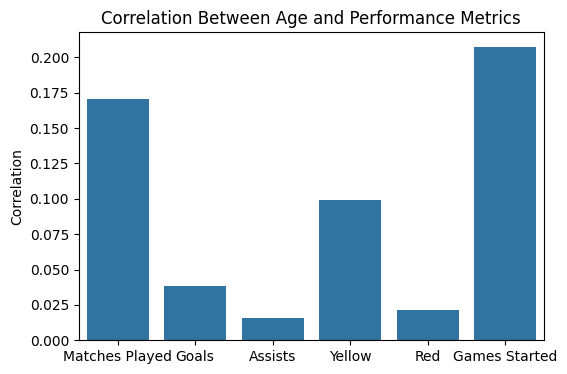

In [21]:
performance_cols = ['Matches Played', 'Goals', 'Assists','Yellow','Red','Games Started']

corrs = {}
for col in performance_cols:
    cor = df[col].corr(df['Age_Years'])
    corrs[col] = cor
for col, cor in sorted(corrs.items(), key=lambda item: item[1], reverse=True):
    print(f"Correlation between {col} and age: {cor}")

plt.figure(figsize=(6,4))
sns.barplot(x=list(corrs.keys()), y=list(corrs.values()))
plt.title("Correlation Between Age and Performance Metrics")
plt.ylabel("Correlation")
plt.show()

In [22]:
# Scale performance metrics
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[performance_cols] = scaler.fit_transform(df[performance_cols])
df.loc[:, 'performance_composite'] = df_scaled[performance_cols].mean(axis=1)

df['performance_composite'].head()

0    0.308609
1    0.000000
2    0.085025
3    0.407114
4    0.143246
Name: performance_composite, dtype: float64

In [23]:
print("Correlation of age with composite performance metric:")
print(df['performance_composite'].corr(df['Age_Years']))

Correlation of age with composite performance metric:
0.1729442335480279


In [24]:
ages = df[['Age_Years']]
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df.loc[:, 'age_cluster'] = kmeans.fit_predict(ages)
# Determine cluster meaning
cluster_order = df.groupby('age_cluster')['Age_Years'].mean().sort_values().index.tolist()

mapping = {
    cluster_order[0]: "Young",
    cluster_order[1]: "Youth",
    cluster_order[2]: "Old"
}

df.loc[:, 'age_group'] = df['age_cluster'].map(mapping)
df[['Age_Years', 'age_group']].head()

,Age_Years,age_group
0,25,Youth
1,19,Young
2,19,Young
3,26,Youth
4,28,Youth


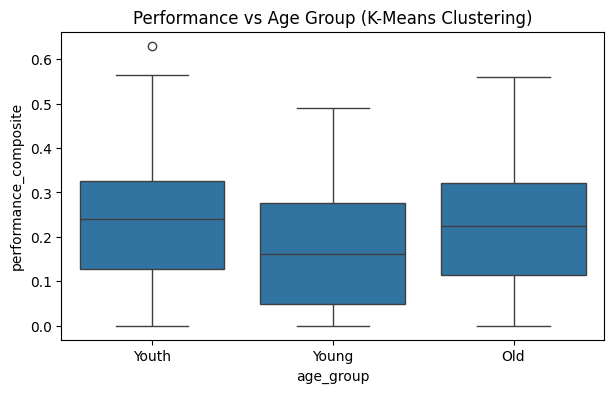

In [25]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x='age_group', y='performance_composite')
plt.title("Performance vs Age Group (K-Means Clustering)")
plt.show()

In [26]:
corr_value = df['performance_composite'].corr(df['Age_Years'])
print("Correlation:", corr_value)

if corr_value > 0:
    print("\nConclusion: Older participants tend to perform BETTER.")
elif corr_value < 0:
    print("\nConclusion: Older participants tend to perform WORSE.")
else:
    print("\nConclusion: Age has NO significant effect on performance.")

print("\nAverage performance per age group:")
print(df.groupby('age_group')['performance_composite'].mean())


Correlation: 0.1729442335480279

Conclusion: Older participants tend to perform BETTER.

Average performance per age group:
age_group
Old      0.219117
Young    0.171697
Youth    0.230297
Name: performance_composite, dtype: float64


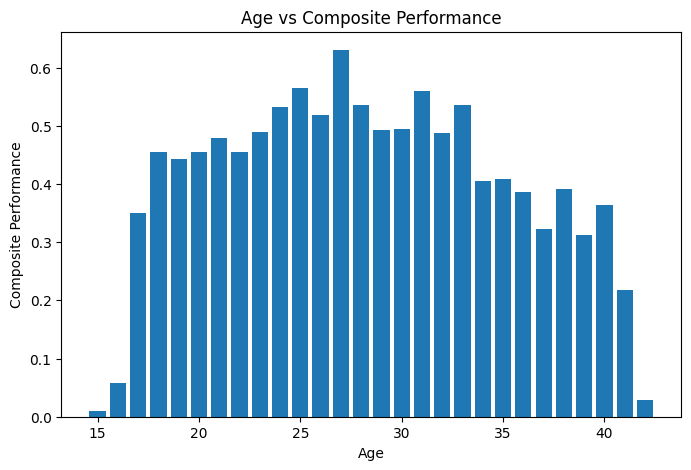

In [27]:
plt.figure(figsize=(8,5))
plt.bar(df['Age_Years'], df['performance_composite'])
plt.title("Age vs Composite Performance")
plt.xlabel("Age")
plt.ylabel("Composite Performance")
plt.show()

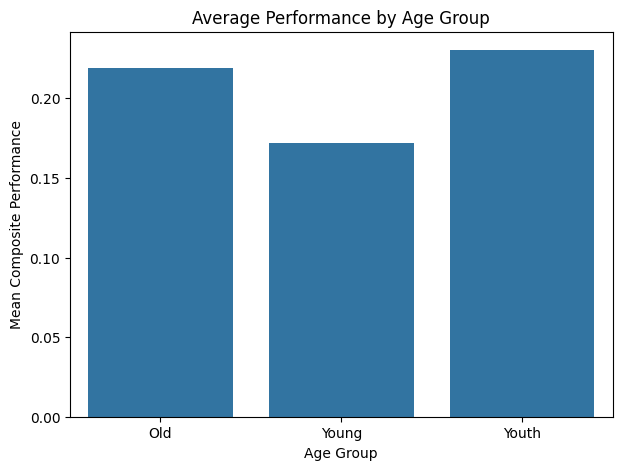

In [28]:
group_means = df.groupby('age_group')['performance_composite'].mean()

plt.figure(figsize=(7,5))
sns.barplot(x=group_means.index, y=group_means.values)
plt.title("Average Performance by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Mean Composite Performance")
plt.show()

In [29]:
young = df[df['age_group'] == "Young"]['performance_composite']
youth = df[df['age_group'] == "Youth"]['performance_composite']
old = df[df['age_group'] == "Old"]['performance_composite']

anova_result = f_oneway(young, youth, old)

corr_value = df['performance_composite'].corr(df['Age_Years'])

In [30]:
print("\n=== FINAL INTERPRETATION ===")

# summary
if corr_value > 0:
    print(f"- Correlation is positive ({corr_value:.2f}): older participants slightly outperform younger ones.")
elif corr_value < 0:
    print(f"- Correlation is negative ({corr_value:.2f}): older participants perform slightly worse.")
else:
    print("- No measurable correlation between age and performance.")

# ANOVA summary
if anova_result.pvalue < 0.05:
    print("- Age groups differ significantly (ANOVA p < 0.05).")
else:
    print("- Differences between age groups are NOT statistically significant (ANOVA p >= 0.05).")

print(f"- Young mean performance:  {group_means['Young']:.4f}")
print(f"- Youth mean performance:  {group_means['Youth']:.4f}")
print(f"- Old mean performance:    {group_means['Old']:.4f}")

if anova_result.pvalue >= 0.05 and abs(corr_value) < 0.2:
    print("\nOverall Conclusion: Age does NOT meaningfully affect performance.")
else:
    if group_means['Youth'] > group_means['Old'] > group_means['Young']:
        print("\nOverall Conclusion: Performance slightly increases with age until middle age, then stabilizes.")
    else:
        print("\nOverall Conclusion: Age does have some effect, but the pattern is weak or inconsistent.")


=== FINAL INTERPRETATION ===
- Correlation is positive (0.17): older participants slightly outperform younger ones.
- Age groups differ significantly (ANOVA p < 0.05).
- Young mean performance:  0.1717
- Youth mean performance:  0.2303
- Old mean performance:    0.2191

Overall Conclusion: Performance slightly increases with age until middle age, then stabilizes.
